In [43]:
from matplotlib import pyplot
from montecarlo import SSA, SSAModel


# initial species counts and measurement time
initital_conditions = {
    "s": [480],
    "i": [20],
    "r": [0],
    "d": [0],
    "time": [0.0],
}


# propensity functions
propensities = {
    0: lambda d: 0.01 * d["s"][-1] * d["i"][-1],
    1: lambda d: 0.1 * d["i"][-1],
    2: lambda d: 0.5 * d["i"][-1],
}


# change in species for each propensity
stoichiometry = {
    0: {"s": -1, "i": 1, "r": 0, "d": 0},
    1: {"s": 0, "i": -1, "r": 0, "d": 1},
    2: {"s": 0, "i": -1, "r": 1, "d": 0}
}


# instantiate the epidemic SSA model
epidemic = SSAModel(
    initital_conditions,
    propensities,
    stoichiometry
)


# instantiate the SSA container with model
epidemic_generator = SSA(epidemic)


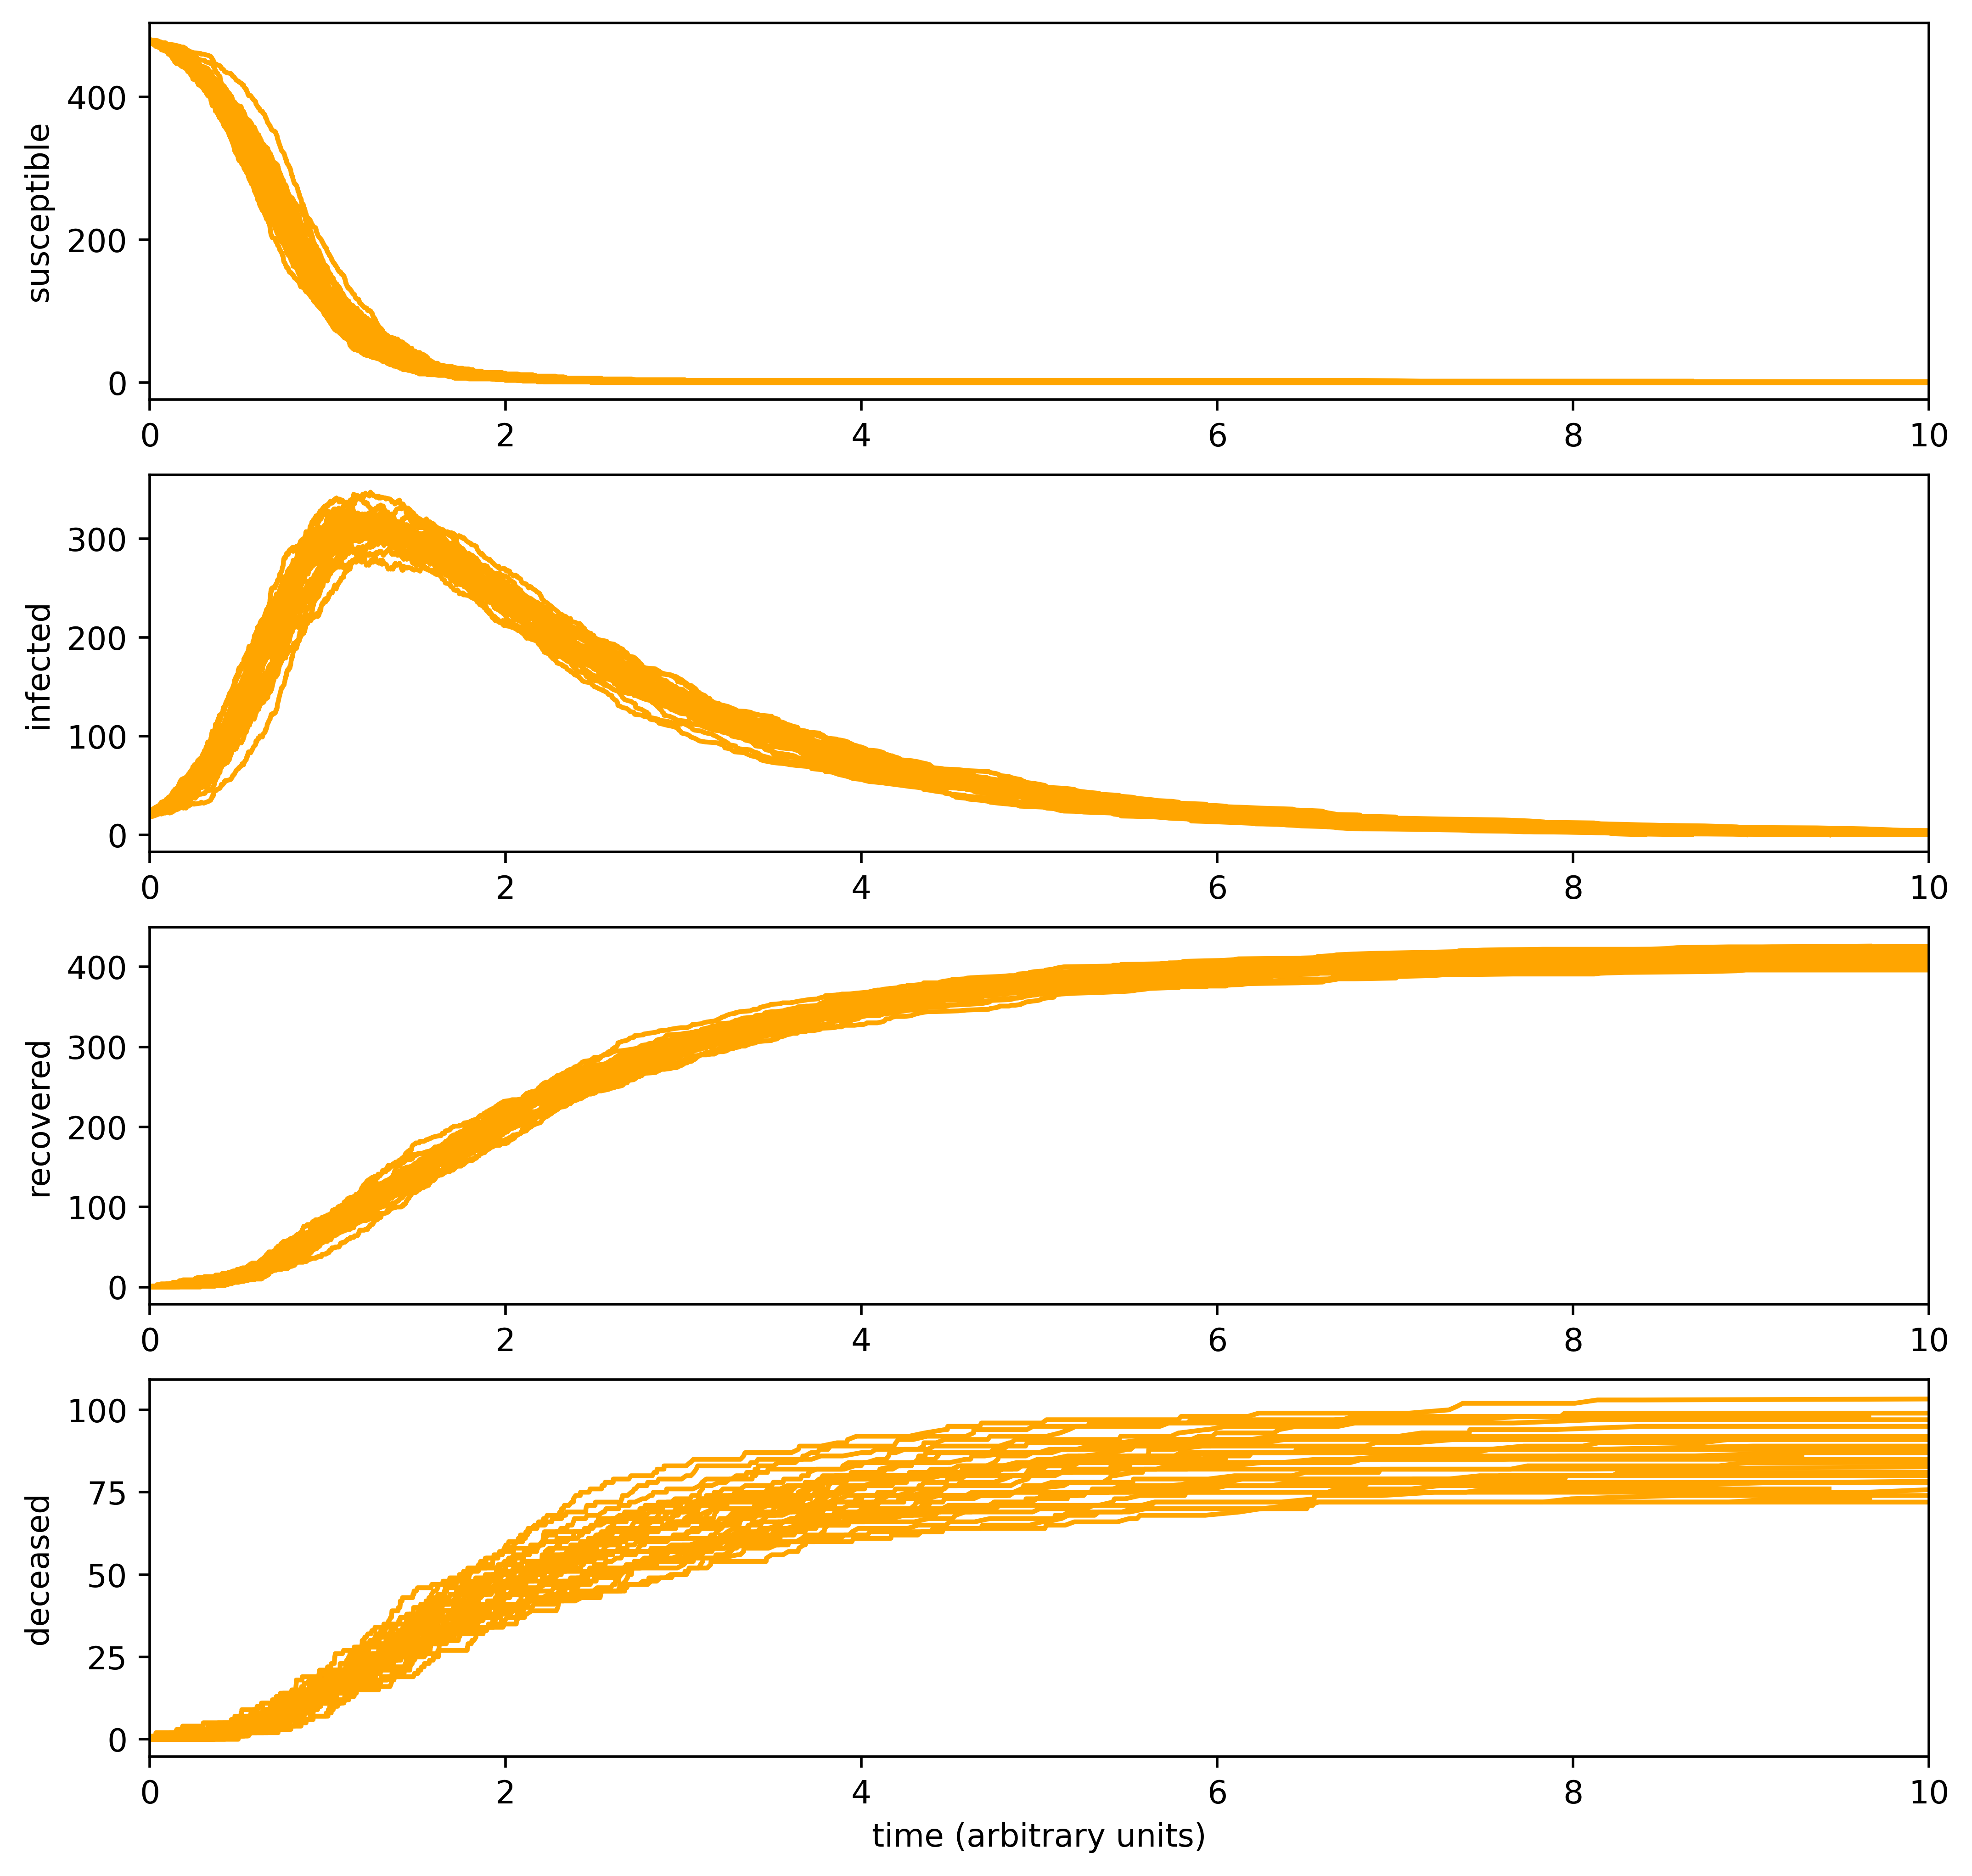

In [46]:
# make a nice, big figure
pyplot.figure(figsize=(10,10), dpi=500)


# make a subplot for susceptible individuals
axes_s = pyplot.subplot(411)
axes_s.set_xlim(0,10)
axes_s.set_ylabel("susceptible")

# make a subplot for infected individuals
axes_i = pyplot.subplot(412)
axes_i.set_xlim(0,10)
axes_i.set_ylabel("infected")

# make a subplot for recovered individuals
axes_r = pyplot.subplot(413)
axes_r.set_xlim(0,10)
axes_r.set_ylabel("recovered")

# make a subplot for deceased individuals
axes_d = pyplot.subplot(414)
axes_d.set_xlim(0,10)
axes_d.set_ylabel("deceased")
axes_d.set_xlabel("time (arbitrary units)")


# simulate and plot acceptable trajectories
trajectories = 0
for trajectory in epidemic_generator.direct():
    axes_s.plot(trajectory["time"], trajectory["s"], color="orange")
    axes_i.plot(trajectory["time"], trajectory["i"], color="orange")
    axes_r.plot(trajectory["time"], trajectory["r"], color="orange")
    axes_d.plot(trajectory["time"], trajectory["d"], color="orange")
    trajectories += 1
    if trajectories == 30:
        break

pyplot.show()


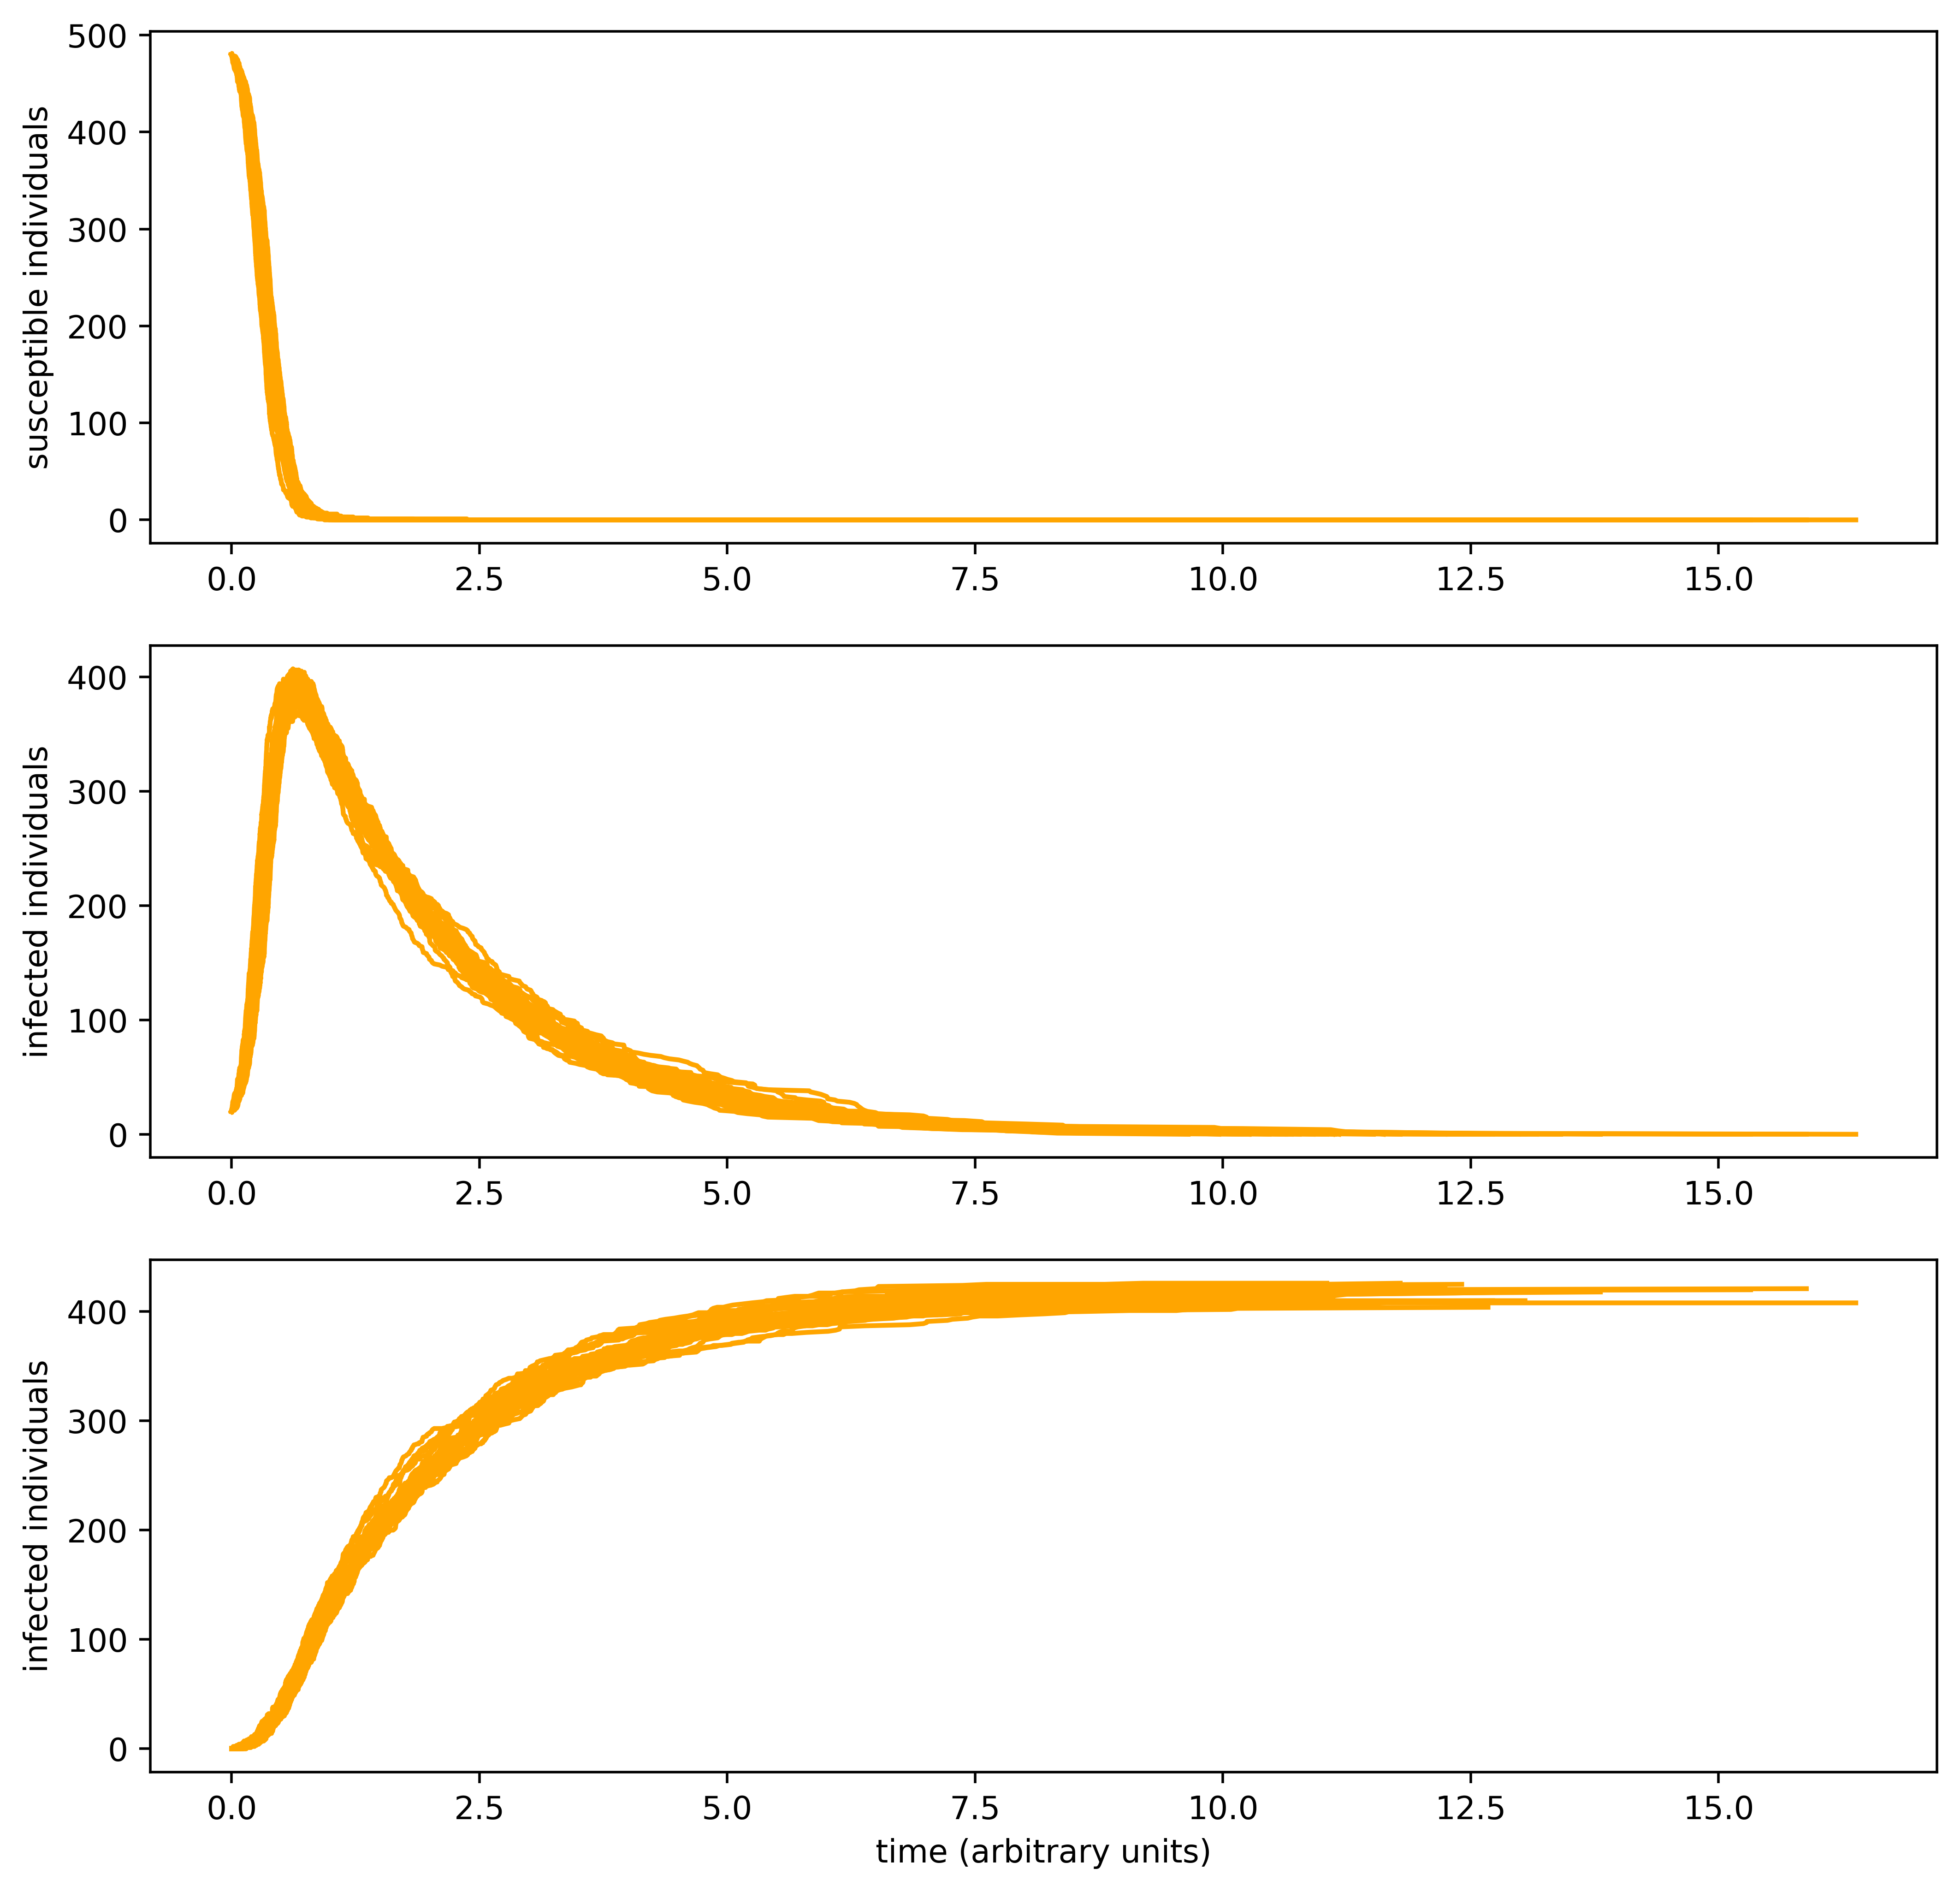

In [29]:
# make a nice, big figure
pyplot.figure(figsize=(10,10), dpi=500)


# make a subplot for susceptible individuals
axes_s = pyplot.subplot(311)
axes_s.set_ylabel("susceptible individuals")

# make a subplot for infected individuals
axes_i = pyplot.subplot(312)
axes_i.set_ylabel("infected individuals")

# make a subplot for recovered individuals
axes_r = pyplot.subplot(313)
axes_r.set_ylabel("infected individuals")
axes_r.set_xlabel("time (arbitrary units)")



# testing the first-reaction method
trajectories = 0
for trajectory in epidemic_generator.first_reaction():
    axes_s.plot(trajectory["time"], trajectory["s"], color="orange")
    axes_i.plot(trajectory["time"], trajectory["i"], color="orange")
    axes_r.plot(trajectory["time"], trajectory["r"], color="orange")
    trajectories += 1
    if trajectories == 30:
        break

pyplot.show()


# Stochastic simulation algorithm
Will Fatherley
<hr>

## Summary
The _stochastic simulation algorithm_ (SSA) was developed over the twentieth century, like most other MC methods. A sizeable fraction of the literature is dedicated to either improving it's complexity, or implementing it to investigate the properties of reactive chemical mixtures. Here, the SSA is detailed in the introduction, two formulations are implemented wih Python 3 in the implementation section, which are used in the applications section to perform simulations of systems from epidemiology, queuing theory, and chemical kinetics. Last, in the practicality section their complexity is discussed.

## Introduction

It is likely that the SSA has been well-formulated in probability theory for a good deal of time, but in the context of this discussion, it was first described in 1976 by Daniel T. Gillespie as _a systematic, computer-oriented procedure in which rigorously derived Monte Carlo techniques are employed to numerically simulate the very Markov process that the master equation describes analytically._ In Gillespie's works, the SSA was implemented to simulate reactive chemical mixtures. In such processes, a set of chemical species (i.e. categories with populations) spontaneously coalesce with and decay from one-another following a so-called stoichiometry, which can be quite simple (i.e. the process has a single elementary reaction or event), or be inoordinately complex (the process has many thousands of elementary reactions or events). For example, the reaction $2H_{2} + O_{2} \rightarrow 2H_{2}O$ is known to involve about eight unique species and about twenty elementary events, depending on the conditions. In this way, the global reactive process might start off with a lot of $H_{2}$ and $O_{2}$ molecules, but as time goes by their populations shrink as others grow, and then those others shrink as $H_{2}O$ grows, and so forth (vauguely speaking).

Gillespie points out that for the $j$th elementary reaction of a process, there exists a "reaction parameter", $c_{j}$, that characterizes that elementary reaction like so--

$$c_{j} \delta t + o(\delta t):= \text{average probability, to first order in }\delta t \text{, that elementary reaction }j\text{ will occur in the next time interval }\delta t.$$

In chemical-kinetic applications, the reaction parameter is analogous in meaning to the "rate constant", which is derived with spatial and thermodynamic arguments (exercise: give the dimension of $c_{j}$). Deriving each of the necessary $c_{j}$s for a Markov process outside of chemical kinetics might not involve spatial or thermodynamic arguments. In any case, the probabilistic interpretation of each $c_{j}$ means that $j$ is a random variable, such that

$$p(j) = \frac{c_{j}}{\sum_{j}c_{j}}.$$

Note that there is no special way to sort the $j$ elementary events at implementation time, but for the SSA to work, they should remain sorted as they were in the first iteration.

The next step in deriving the SSA is to find a probabilistic expression for the _time to the next reaction_, $\tau$. In queuing theory this is called the _sojourn time_. In basically _every single_ Markov process, the sojourn time, is exponentially distributed. So then

$$p(\tau) = exp(-\sum_{j}c_{j}\tau).$$

As can be seen, the SSA simulates a Markov process by considering two procedural facets: how the system updates it's populations (i.e. $p(j)$), and how long the system waits until it performs another update of it's populations (i.e. $p(\tau)$). Thus each iteration within a single simulation requires two Monte Carlo steps.

To update populations the following is evaluated with a pseudorandom float, $r$ on $[0,1]$ (exercise: explain what is going on in this Monte Carlo step):

$$j = \text{the smallest integer satisfying} \sum_{j'}^{j} c_{j'} > r\sum_{j}c_{j}$$

To find the sojourn time, the familiar exponential distribution inversion is invoked with another pseudorandom float on $[0,1]$:

$$\tau = \frac{1}{\sum_{j}c_{j}}log_{e}(\frac{1}{r})$$

Viewing the populations of the system being simulated as a dynamical vector $x$, the "direct-method" of the SSA is as follows:

1. Initialize the time $t = t_{0}$ and systems state to $x=x_{0}$
2. Evaluate each $c_{j}$ if it depends on $x$ or $t$, and compute $\sum_{j}c_{j}$
3. Evaluate the Monte Carlo steps to update $t$ and $x$
4. Update $t$ and $x$ as desired
5. Return to step 2 or else exit the simulation

The "first-reaction" method of the SSA is as follows:

1. Initialize the time $t = t_{0}$ and systems state to $x=x_{0}$
2. Draw $j$ pseudorandom numbers and compute a $\hat{\tau}$ with each one
3. Set $\tau$ as the smallest $\hat{\tau}$, and $j$ as the index of the chosen $\hat{\tau}$
4. Update $t$ and $x$ as desired
5. Return to step 2 or else exit the simulation

## Implementation
The SSAs as presented above follow Gillespie, but are naive in at least one respect: they don't specify how to avoid updating the system's categorical populations in nonsensical ways. For example, without certain precautions, it could be possible for a given population to dip below zero, which is nonsense. Thus to implement the SSA, a helper class is first implemented that furnishes a public interface for a "model":
```Python
class SSAModel(dict):
    """Container for SSA model"""

    def __init__(
        self,
        initial_conditions,
        propensities,
        stoichiometry,
        max_duration=None
    ):
        """Initialize model"""
        super().__init__(**initial_conditions)
        self.max_duration = max_duration
        self.reactions = list()
        self.excluded_reactions = list()
        for reaction,propensity in propensities.items():
            if propensity(self) == 0.0:
                self.excluded_reactions.append(
                    (
                        reaction,
                        stoichiometry[reaction],
                        propensity
                    )
                )
            else:
                self.reactions.append(
                    (
                        reaction,
                        stoichiometry[reaction],
                        propensity
                    )
                )

    def exit(self):
        """Return True to break out of trajectory"""

        # return True if no more reactions
        if len(self.reactions) == 0: return True
        else: return False

        # return True if there is no time left
        if self.max_duration is not None:
            if self["time"][-1] >= self.max_duration:
                return True

    def curate(self):
        """Validate and invalidate model reactions"""
        
        # evaulate possible reactions
        reactions = []
        while len(self.reactions) > 0:
            reaction = self.reactions.pop()
            if reaction[2](self) == 0:
                self.excluded_reactions.append(reaction)
            else:
                reactions.append(reaction)
        reactions.sort()
        self.reactions = reactions

        # evaluate impossible reactions
        excluded_reactions = []
        while len(self.excluded_reactions) > 0:
            reaction = self.excluded_reactions.pop()
            if reaction[2](self) > 0:
                self.reactions.append(reaction)
            else:
                excluded_reactions.append(reaction)
        excluded_reactions.sort()
        self.excluded_reactions = excluded_reactions

    def reset(self):
        """Clear the trajectory"""

        # reset species to initial conditions
        for key in self: del self[key][1:]

        # reset reactions per initial conditions
        self.curate()
```

## Applications

Regardless of the ontological aspects involved in Gillespie's work deriving the SSA, it is broadly applicable to many observable processes. Consider as an example the COVID-19 pandemic, in which a population of individuals are all initially in a susceptible state ($S$), and can transition to the infected ($I$) state. In the infected state, an individual can then either recover (state $R$) or die (state $D$). Supposing that the timescale of this pandemic is significantly shorter than the average lifespan of any individual, it can be assumed that transitions from the recovered state are not possible. Schematically, here are the possibilities--

$$S \rightarrow I,$$

$$I \rightarrow D,$$

$$I \rightarrow R.$$



## References

\[1\] Gillespie, Daniel T. (2007). "Stochastic Simulation of Chemical Kinetics". The Journal of Physical Chemistry. 58: 35–55.

\[2\] Gillespie, Daniel T. (1976). "A General Method for Numerically Simulating the Stochastic Time Evolution of Coupled Chemical Reactions". Journal of Computational Physics. 22 (4): 403–434.